# Overview

In [2]:
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
from   tabulate import tabulate

import Analysis.config.config          as cfg
from   Analysis.utils              import G4Tools, XTools
from   Analysis.models.PDGParticle import PDGParticle_dict

In [52]:
def show_event(df, event_num, draw_cube_flag=True):
    event_df = df[df['fEvent'] == event_num]
    print(tabulate(event_df.head(30), headers='keys', tablefmt='grid', showindex=False))
    G4Tools.visualise_event(event_df, draw_cube_flag=draw_cube_flag)

DATA_PATH_AmBe = cfg.G4Sims_DIR / "G4P-AmBeCube" / "loc_data" / "PLY_plate_and_blocks" / "output0_nt_Hits.csv"
DATA_PATH_CoCs = cfg.G4Sims_DIR / "G4P-CoCsCube" / "loc_data" / "dump" / "run_0.csv"

column_names = ["fEvent", "fEntry", "fPreProc", "fPostProc", "fTrackID", 
                "fParentID", "fPDG", "fKinetic", "fEdep", 
                "fX1", "fY1", "fZ1", "fX2", "fY2", "fZ2", "Copy"]

df_AmBe = G4Tools.gen_run_dataframe(DATA_PATH_AmBe, column_names=column_names)
df_CoCs = G4Tools.gen_run_dataframe(DATA_PATH_CoCs, column_names=column_names)


## Visualise Events: AmBeCube

+----------+----------+----------------+------------------+------------+-------------+------------+------------+-----------+-----------+---------+---------+-----------+---------+---------+--------+
|   fEvent |   fEntry | fPreProc       | fPostProc        |   fTrackID |   fParentID |       fPDG |   fKinetic |     fEdep |       fX1 |     fY1 |     fZ1 |       fX2 |     fY2 |     fZ2 |   Copy |
+==========+==========+================+==================+============+=============+============+============+===========+===========+=========+=========+===========+=========+=========+========+
|   102666 |        1 | Transportation | neutronInelastic |          1 |           0 |       2112 |  0.206771  | 0         | -0.74384  |  95     | 199.811 | -0.814344 | 104.004 | 196.949 |      2 |
+----------+----------+----------------+------------------+------------+-------------+------------+------------+-----------+-----------+---------+---------+-----------+---------+---------+--------+
|   102666

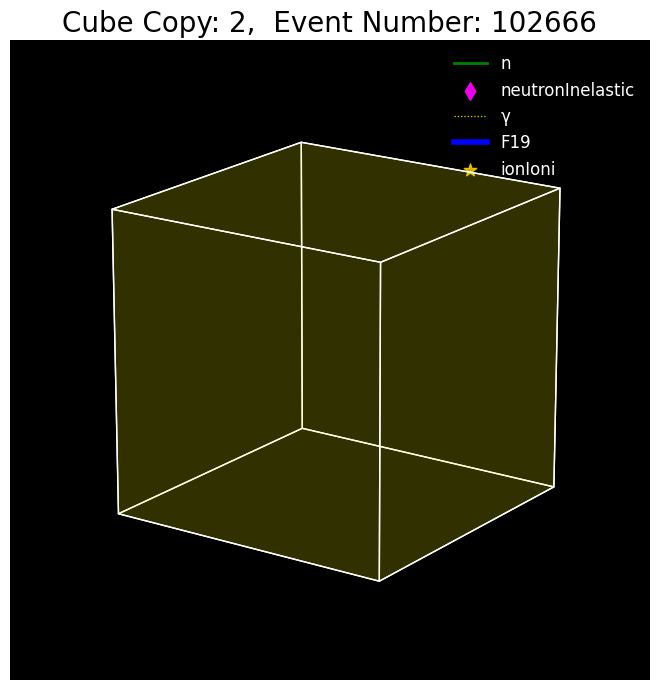

In [12]:
event_num = 98

# Get array of event numbers
fEvent_arr      = np.unique(np.array(df_AmBe["fEvent"]))

# Get array of events where an interaction happens
df_intr         = df_AmBe[(df_AmBe["fEntry"]==1) & (df_AmBe["fPostProc"] != "Transportation")]
fEvent_intr_arr = np.unique(np.array(df_intr["fEvent"]))

show_event(df_AmBe, event_num=fEvent_intr_arr[event_num])

## Energy Depositions: AmBeCube

+-----+--------------+-----------------+------------+
|     |   Edep (MeV) |   Edep [MeV/Hr] | Colour     |
+=====+==============+=================+============+
| e⁻  |        71.38 |        20658.8  | cyan       |
+-----+--------------+-----------------+------------+
| e⁺  |         5.13 |         1485.44 | red        |
+-----+--------------+-----------------+------------+
| γ   |         0.01 |            2.04 | gold       |
+-----+--------------+-----------------+------------+
| n   |         2.07 |          598.95 | green      |
+-----+--------------+-----------------+------------+
| p   |         0    |            0    | maroon     |
+-----+--------------+-----------------+------------+
| Li7 |        37.6  |        10881.4  | magenta    |
+-----+--------------+-----------------+------------+
| Li6 |         1.25 |          360.7  | purple     |
+-----+--------------+-----------------+------------+
| F19 |        11.76 |         3402.28 | blue       |
+-----+--------------+------

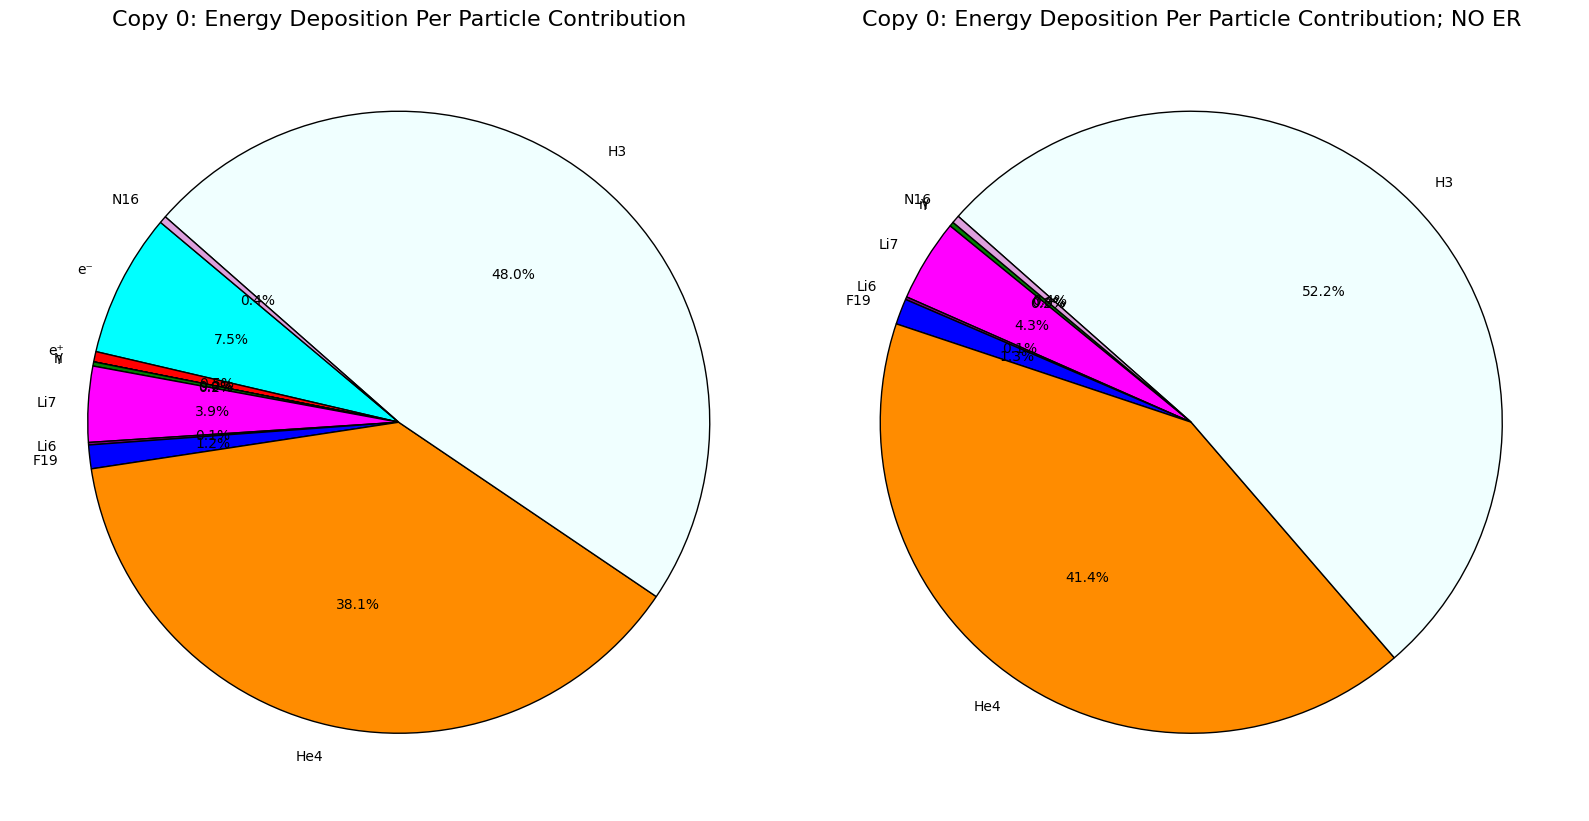

In [53]:
simulated_events = 1e6
days_elapsed     = XTools.days_elapsed(cfg.AMBE_PRODUCTION_DATE, (2025, 10, 17))
activity         = XTools.get_activity(cfg.AMBE_INIT_ACTIVITY, cfg.AMBE_HALF_LIFE, days_elapsed) #Bq

simulated_time = simulated_events / activity  # seconds

to_hours_scale = 3600 / simulated_time

copy_num = 0
df_AmBe_0 = df_AmBe[df_AmBe['Copy'] == copy_num]

rows = []
for key, particle in PDGParticle_dict.items():
    edep = G4Tools.get_particle_edep(df_AmBe_0, key)
    rows.append([particle.label, np.round(edep, 2), np.round(edep * to_hours_scale,2), particle.colour])

print(tabulate(rows, headers=["Edep (MeV)", "Edep [MeV/Hr]", "Colour"], tablefmt="grid"))

plt.rcParams.update({
    "text.color": "black",
    "legend.fontsize": 16,    # legend text size
    "legend.title_fontsize": 16
})

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,16))

pie_labels = [row[0] for row in rows if row[1] > 0]
pie_sizes  = [row[1] for row in rows if row[1] > 0]
pie_colors = [row[3] for row in rows if row[1] > 0]

ax1.pie(pie_sizes, labels=pie_labels, colors=pie_colors, autopct='%1.1f%%',
        startangle=140, wedgeprops=dict(edgecolor='black'))
ax1.set_title(f"Copy {copy_num}: Energy Deposition Per Particle Contribution", fontsize=16)

ax2.pie(pie_sizes[2:], labels=pie_labels[2:], colors=pie_colors[2:], autopct='%1.1f%%',
        startangle=140, wedgeprops=dict(edgecolor='black'))
ax2.set_title(f"Copy {copy_num}: Energy Deposition Per Particle Contribution; NO ER", fontsize=16)

plt.tight_layout();

In [54]:
PDGParticle_dict

{11: PDGParticle(name='Electron', label='e⁻', colour='cyan', linewidth=1, linestyle='dashdot'),
 -11: PDGParticle(name='Positron', label='e⁺', colour='red', linewidth=1, linestyle='dashdot'),
 22: PDGParticle(name='Gamma', label='γ', colour='gold', linewidth=0.9, linestyle='dotted'),
 2112: PDGParticle(name='Neutron', label='n', colour='green', linewidth=2, linestyle='solid'),
 2212: PDGParticle(name='Proton', label='p', colour='maroon', linewidth=2, linestyle='solid'),
 1000030070: PDGParticle(name='Lithium-7', label='Li7', colour='magenta', linewidth=3, linestyle='solid'),
 1000030060: PDGParticle(name='Lithium-6', label='Li6', colour='purple', linewidth=3, linestyle='solid'),
 1000090190: PDGParticle(name='Fluorine-19', label='F19', colour='blue', linewidth=4, linestyle='solid'),
 1000090200: PDGParticle(name='Fluorine-20', label='F20', colour='darkblue', linewidth=4.2, linestyle='solid'),
 1000020040: PDGParticle(name='Helium-4', label='He4', colour='darkorange', linewidth=1.5, lin

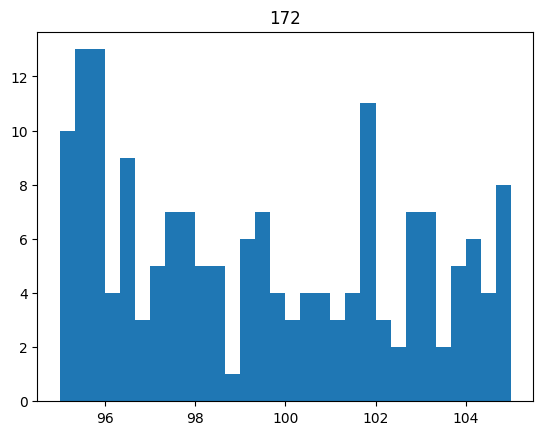

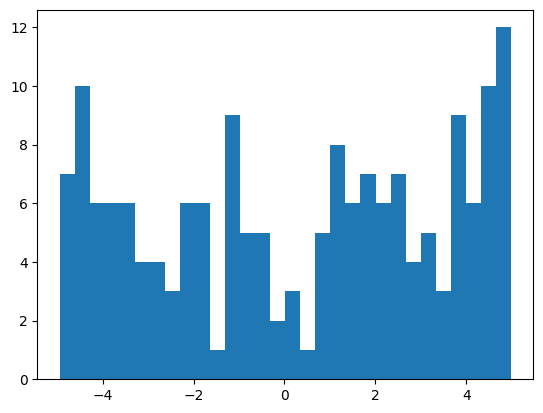

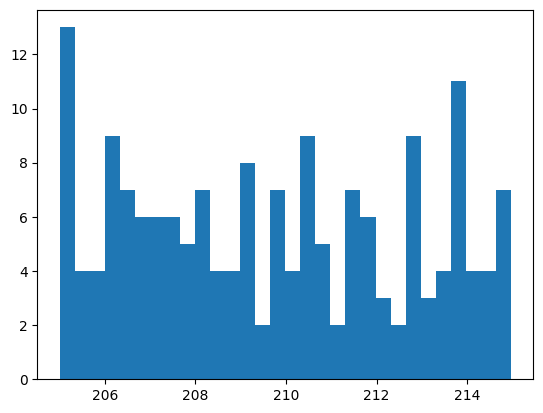

In [57]:
particle_num = 1000020040
spec_df = df_AmBe_0[df_AmBe_0["fPDG"]==particle_num]

x_arr = np.array(spec_df["fX1"])
y_arr = np.array(spec_df["fY1"])
z_arr = np.array(spec_df["fZ1"])

bins = 30
plt.hist(x_arr, bins = bins)
plt.title(len(x_arr))
plt.show()

plt.hist(y_arr, bins = bins)
plt.show()

plt.hist(z_arr, bins = bins)
plt.show()

+-----+--------------+------------+
|     |   Edep (MeV) | Colour     |
+=====+==============+============+
| e⁻  |      7560    | cyan       |
+-----+--------------+------------+
| e⁺  |         1.22 | red        |
+-----+--------------+------------+
| γ   |         0.02 | gold       |
+-----+--------------+------------+
| n   |         0    | green      |
+-----+--------------+------------+
| p   |         0    | maroon     |
+-----+--------------+------------+
| Li7 |         0    | magenta    |
+-----+--------------+------------+
| Li6 |         0    | purple     |
+-----+--------------+------------+
| F19 |         0    | blue       |
+-----+--------------+------------+
| F20 |         0    | darkblue   |
+-----+--------------+------------+
| He4 |         0    | darkorange |
+-----+--------------+------------+
| He6 |         0    | orange     |
+-----+--------------+------------+
| H3  |         0    | azure      |
+-----+--------------+------------+
| N16 |         0    | plum 

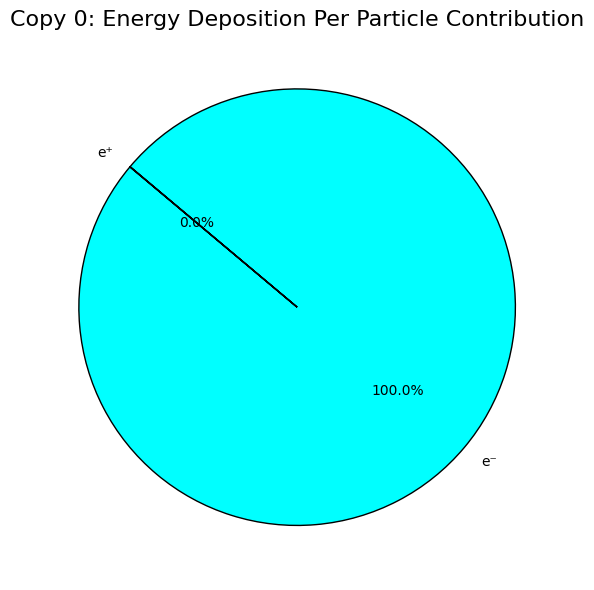

In [27]:
copy_num = 0
df_CoCs_0 = df_CoCs[df_CoCs['Copy'] == copy_num]

rows = []
for key, particle in PDGParticle_dict.items():
    edep = G4Tools.get_particle_edep(df_CoCs_0, key)
    rows.append([particle.label, np.round(edep, 2), particle.colour])

print(tabulate(rows, headers=["Edep (MeV)", "Colour"], tablefmt="grid"))

plt.rcParams.update({
    "text.color": "black",
    "legend.fontsize": 16,    # legend text size
    "legend.title_fontsize": 16
})

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

pie_labels = [row[0] for row in rows if row[1] > 0]
pie_sizes  = [row[1] for row in rows if row[1] > 0]
pie_colors = [row[2] for row in rows if row[1] > 0]

ax1.pie(pie_sizes[:2], labels=pie_labels[:2], colors=pie_colors[:2], autopct='%1.1f%%',
        startangle=140, wedgeprops=dict(edgecolor='black'))
ax1.set_title(f"Copy {copy_num}: Energy Deposition Per Particle Contribution", fontsize=16)

plt.tight_layout();

In [48]:
def run_overview(df, simulated_events, irrad_date, copy_num=0, masked_particles=[]):

    days_elapsed     = XTools.days_elapsed(cfg.AMBE_PRODUCTION_DATE, (2025, 10, 17))
    activity         = XTools.get_activity(cfg.AMBE_INIT_ACTIVITY, cfg.AMBE_HALF_LIFE, days_elapsed) #Bq

    simulated_time = simulated_events / activity  # seconds

    to_hours_scale = 3600 / simulated_time

    df = df[df['Copy'] == copy_num]

    rows = []
    for key, particle in PDGParticle_dict.items():
        if particle.label not in masked_particles:  # Skip masked particles
            edep = G4Tools.get_particle_edep(df, key)
            rows.append([particle.label, np.round(edep, 2), np.round(edep * to_hours_scale,2), particle.colour])

    print(tabulate(rows, headers=["Edep (MeV)", "Edep [MeV/Hr]", "Colour"], tablefmt="grid"))

    plt.rcParams.update({
        "text.color": "black",
        "legend.fontsize": 16,    # legend text size
        "legend.title_fontsize": 16
    })

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,16))

    pie_labels = [row[0] for row in rows if row[1] > 0]
    pie_sizes  = [row[1] for row in rows if row[1] > 0]
    pie_colors = [row[3] for row in rows if row[1] > 0]

    ax1.pie(pie_sizes, labels=pie_labels, colors=pie_colors, autopct='%1.1f%%',
            startangle=140, wedgeprops=dict(edgecolor='black'))
    ax1.set_title(f"Copy {copy_num}: Energy Deposition Per Particle Contribution", fontsize=16)

    # Only show second pie if we have more than 2 entries
    if len(pie_sizes) > 2:
        ax2.pie(pie_sizes, labels=pie_labels, colors=pie_colors, autopct='%1.1f%%',
                startangle=140, wedgeprops=dict(edgecolor='black'))
        ax2.set_title(f"Copy {copy_num}: Energy Deposition Per Particle Contribution; NO ER", fontsize=16)
    else:
        ax2.set_visible(False)

    plt.tight_layout();

+-----+--------------+-----------------+------------+
|     |   Edep (MeV) |   Edep [MeV/Hr] | Colour     |
+=====+==============+=================+============+
| e⁻  |        46.42 |        13434.1  | cyan       |
+-----+--------------+-----------------+------------+
| e⁺  |         5.51 |         1595.3  | red        |
+-----+--------------+-----------------+------------+
| γ   |         0.01 |            2.42 | gold       |
+-----+--------------+-----------------+------------+
| n   |         3.8  |         1100.85 | green      |
+-----+--------------+-----------------+------------+
| p   |         0    |            0    | maroon     |
+-----+--------------+-----------------+------------+
| Li7 |        51.97 |        15041.2  | magenta    |
+-----+--------------+-----------------+------------+
| Li6 |         3.98 |         1151.73 | purple     |
+-----+--------------+-----------------+------------+
| F19 |        20.14 |         5827.82 | blue       |
+-----+--------------+------

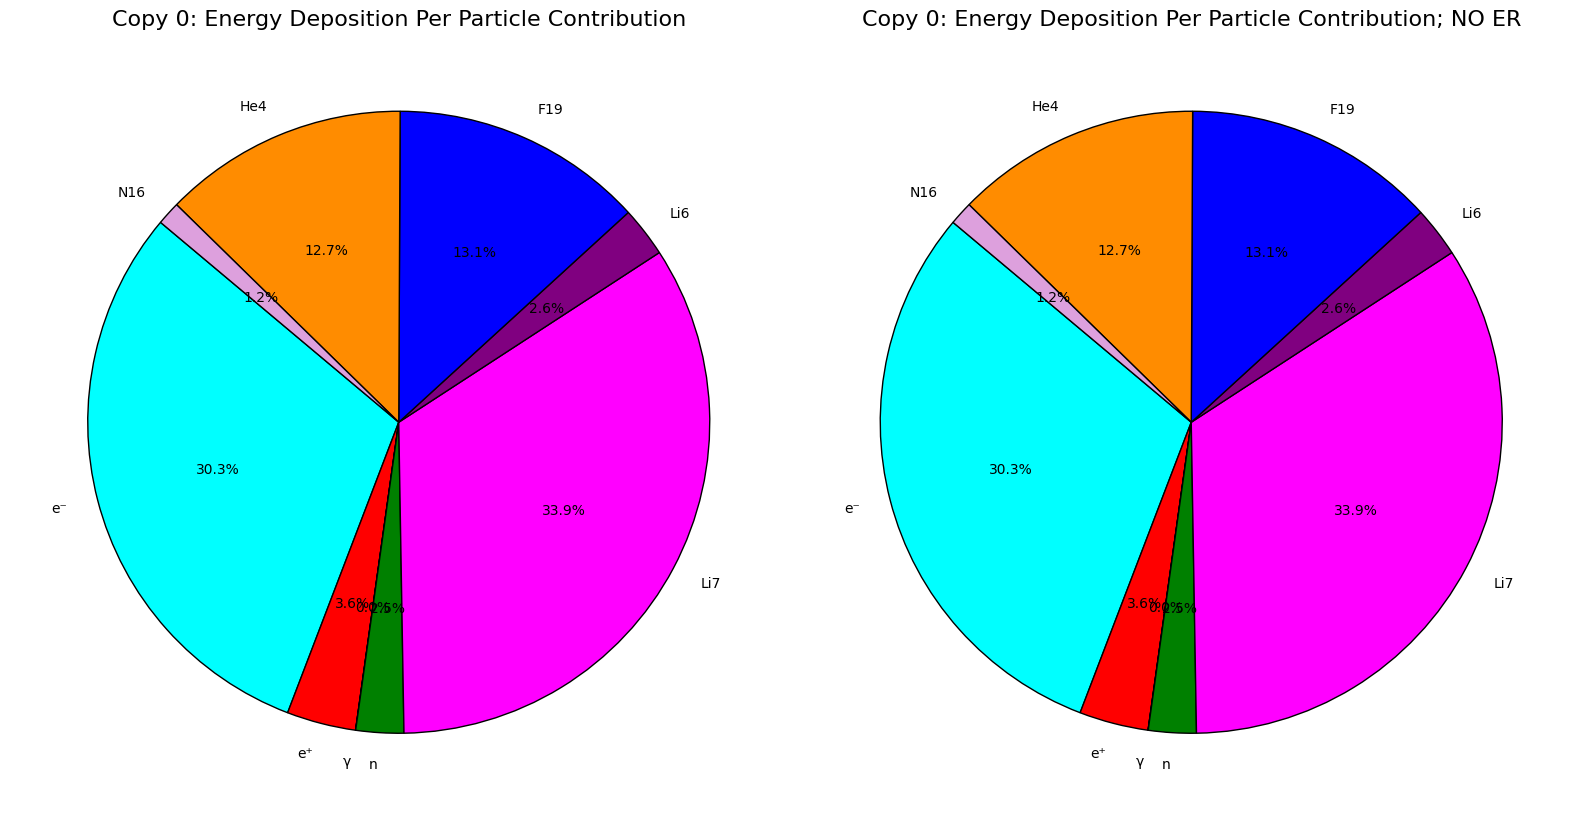

In [51]:
run_overview(df_AmBe, simulated_events=1e6, irrad_date=(2025,10,17), copy_num=0, masked_particles=[])

(array([1.81736e+05, 1.04460e+04, 6.47500e+03, 4.22700e+03, 3.04500e+03,
        2.27400e+03, 1.98800e+03, 1.52400e+03, 1.26700e+03, 1.13500e+03,
        1.03800e+03, 8.72000e+02, 8.25000e+02, 6.91000e+02, 6.57000e+02,
        5.76000e+02, 5.27000e+02, 4.50000e+02, 4.21000e+02, 3.94000e+02,
        3.73000e+02, 3.75000e+02, 4.25000e+02, 5.16000e+02, 5.60000e+02,
        5.77000e+02, 4.60000e+02, 3.67000e+02, 2.84000e+02, 2.17000e+02,
        2.04000e+02, 1.32000e+02, 1.01000e+02, 8.10000e+01, 6.50000e+01,
        5.20000e+01, 4.80000e+01, 3.90000e+01, 3.10000e+01, 2.00000e+01,
        1.70000e+01, 2.10000e+01, 1.20000e+01, 1.20000e+01, 9.00000e+00,
        1.00000e+00, 4.00000e+00, 2.00000e+00, 3.00000e+00, 2.00000e+00]),
 array([0.       , 0.0215856, 0.0431712, 0.0647568, 0.0863424, 0.107928 ,
        0.1295136, 0.1510992, 0.1726848, 0.1942704, 0.215856 , 0.2374416,
        0.2590272, 0.2806128, 0.3021984, 0.323784 , 0.3453696, 0.3669552,
        0.3885408, 0.4101264, 0.431712 , 0.453

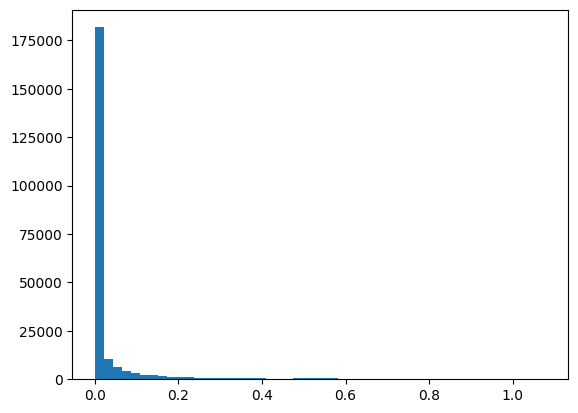

In [57]:
edep_arr = np.array(df_CoCs["fEdep"])
plt.hist(edep_arr, bins = 50)